# Four-step Transportation Model

This is an update of a [blog post](https://davidabailey.com/articles/Creating-a-Four-step-Transportation-Model-in-Python) I wrote three years ago. I have since created classes to simplify the process of creating a four-step model. The two classes we will use are Zones and OriginDestinationDataFrame.

In [1]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import us

from dpd.modeling import Zones, OriginDestinationDataFrame

/usr/local/lib/python3.9/site-packages/geopandas/_compat.py:111: UserWarning: The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
YEAR = "2017"

state = widgets.Select(
    options=list(map(lambda x: x.name, us.STATES)), description="State", rows=10
)
display(state)

Select(description='State', options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Co…

The Zones class defines our analysis zones for the four step model. It is based on a Geopandas GeoDataFrame so it includes a geometry column that maps each zone. The other important columns are Production and Attraction which include the production and attraction data for each zone and the index which is used by the OriginDestinationDataFrame. Zones can be automatically created from US Census data with the from_uscensus method. Otherwise you need to create a GeoDataFrame with the aforementioned columns.

In [3]:
zones = Zones.from_uscensus(str(us.states.lookup(state.value).fips), YEAR)

/usr/local/lib/python3.9/site-packages/dpd/uscensus/get_uscensus_data.py:31: FutureWarning: Could not cast to int64, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  dataframe = pandas.DataFrame(


In [4]:
zones.head(1)

Name  Production  \
GEOID                                                                      
35049001002  Census Tract 10.02, Santa Fe County, New Mexico        3612   

             Attraction state county   tract STATEFP COUNTYFP TRACTCE NAME_y  \
GEOID                                                                          
35049001002           0    35    049  001002      35      049  001002  10.02   

             ... FUNCSTAT    ALAND AWATER     INTPTLAT      INTPTLON  \
GEOID        ...                                                       
35049001002  ...        S  2086269      0  +35.6654818  -105.9636628   

                                                      geometry  \
GEOID                                                            
35049001002  POLYGON ((-105.97726 35.66269, -105.97708 35.6...   

            ProductionAttractionSum Production Density  Attraction Density  \
GEOID                                                                        
35049001002                    3612        1731.320362                 0.0   

             ProductionAttractionSum Density  
GEOID                                         
35049001002                      1731.320362  

[1 rows x 22 columns]

One of nice things about this being a GeoDataFrame is that you can easily plot it. In this case we can plot the "Production density" which is really just the population density. We can see each zone (big in rural areas, small in urban areas) and we can see the urban areas have higher densities. This is step one of our four-step model.

<AxesSubplot:>

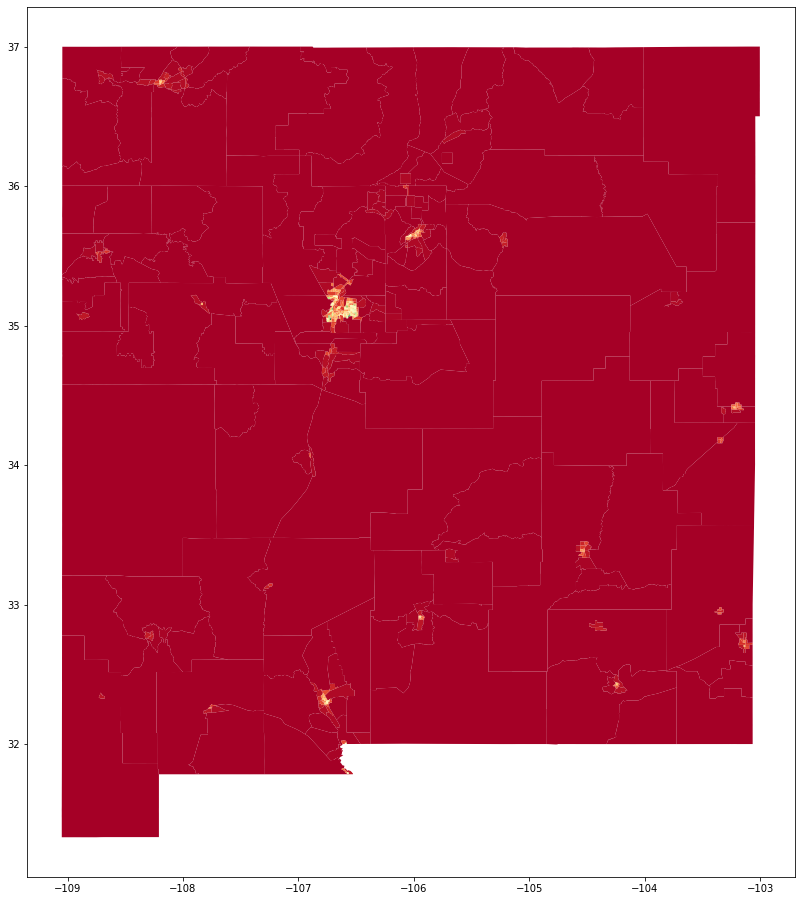

In [5]:
zones["Production density"] = zones["Production"].map(int) / zones["ALAND"]
fig = plt.figure(figsize=(18, 16))
ax = fig.add_subplot(111)
zones.plot(column="Production density", cmap="RdYlGn", ax=ax)

Next we need to create a OriginDestinationDataFrame. We could compute this directly from our Zones object above, but we can also create this by downloading the US Census LODES data using the from_lodes method. This data is already organized as an origin-destination matrix. This is step two of the four-step model.

In [6]:
od = TripDataFrame.from_lodes(us.states.lookup(state.value).abbr.lower(), YEAR)

/usr/local/lib/python3.9/site-packages/dpd/modeling/origin_destination_dataframe.py:41: DtypeWarning: Columns (28,29,31,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  xwalk = pandas.read_csv(download_lodes_xwalk(st))


In [7]:
od

w_geocode          h_geocode  S000  SA01  \
trct_w      trct_h                                                          
35001000107 35001000107   6300180019282126   6300180019290148    22     0   
            35001000108   1050030003214025   1050030003244008     3     1   
            35001000109    350010001071008    350010001091010     1     0   
            35001000111    350010001071008    350010001112007     1     1   
            35001000112   1750050005356019   1750050005607029     5     0   
...                                    ...                ...   ...   ...   
35061971400 35061970902   7012394280036520   7012394180421028    22    12   
            35061971000  17180365986092544  17180365790119452    62    15   
            35061971100   4207436568023410   4207436532013085    13     3   
            35061971300   3506197140017249   3506197130011257    11     3   
            35061971400  16128506844079148  16128506844079080    66    16   

                         SA02  SA03  SE01  SE02  SE03  SI01  SI02  SI03  \
trct_w      trct_h                                                        
35001000107 35001000107     9    13     7     8     7     2     0    20   
            35001000108     1     1     0     3     0     0     0     3   
            35001000109     1     0     1     0     0     0     0     1   
            35001000111     0     0     0     0     1     0     0     1   
            35001000112     0     5     3     0     2     1     0     4   
...                       ...   ...   ...   ...   ...   ...   ...   ...   
35061971400 35061970902     4     6     5    11     6     8     8     6   
            35061971000    38     9     4    40    18    13    38    11   
            35061971100     8     2     1     6     6     2     8     3   
            35061971300     7     1     2     6     3     1     2     8   
            35061971400    35    15    14    27    25    13    23    30   

                         createdate  
trct_w      trct_h                   
35001000107 35001000107   363619980  
            35001000108    60603330  
            35001000109    20201110  
            35001000111    20201110  
            35001000112   101005550  
...                             ...  
35061971400 35061970902   404022200  
            35061971000   989854390  
            35061971100   242413320  
            35061971300   202011100  
            35061971400   929251060  

[88273 rows x 13 columns]

Notice we use a multi-index instead of an index and column. This is because most zones do not have trips to other zones. We could unstack this dataframe to create a dataframe with the index as the origin and the columns as the destination. However, this creates many relationships (159,845 or 65% in this case) with no trips (NaN). 

In [8]:
od["S000"].unstack()

trct_h       35001000107  35001000108  35001000109  35001000110  35001000111  \
trct_w                                                                         
35001000107         22.0          3.0          1.0          NaN          1.0   
35001000108          8.0         16.0          6.0          2.0         13.0   
35001000109          5.0         10.0         31.0         16.0          8.0   
35001000110          7.0          8.0          5.0         20.0         15.0   
35001000111          4.0          5.0          1.0          9.0         18.0   
...                  ...          ...          ...          ...          ...   
35061970902          NaN          NaN          NaN          NaN          NaN   
35061971000          NaN          NaN          NaN          1.0          NaN   
35061971100          NaN          NaN          NaN          NaN          NaN   
35061971300          NaN          NaN          NaN          NaN          NaN   
35061971400          2.0          1.0          2.0          5.0          1.0   

trct_h       35001000112  35001000113  35001000114  35001000115  35001000116  \
trct_w                                                                         
35001000107          5.0          2.0          2.0          1.0          1.0   
35001000108          3.0          6.0          3.0          8.0          1.0   
35001000109          8.0         16.0          9.0         14.0          4.0   
35001000110          8.0          7.0          4.0         10.0          3.0   
35001000111          3.0          6.0          5.0          1.0          2.0   
...                  ...          ...          ...          ...          ...   
35061970902          NaN          NaN          NaN          NaN          NaN   
35061971000          1.0          NaN          1.0          NaN          NaN   
35061971100          NaN          NaN          NaN          NaN          NaN   
35061971300          NaN          NaN          NaN          NaN          NaN   
35061971400          1.0          3.0          2.0          2.0          2.0   

trct_h       ...  35061970404  35061970405  35061970700  35061970800  \
trct_w       ...                                                       
35001000107  ...          NaN          NaN          2.0          NaN   
35001000108  ...          NaN          NaN          NaN          NaN   
35001000109  ...          4.0          1.0          1.0          NaN   
35001000110  ...          NaN          NaN          1.0          NaN   
35001000111  ...          2.0          NaN          1.0          2.0   
...          ...          ...          ...          ...          ...   
35061970902  ...          3.0          3.0          4.0          4.0   
35061971000  ...         19.0          6.0         30.0         48.0   
35061971100  ...          NaN          NaN          4.0         11.0   
35061971300  ...          1.0          NaN         14.0         10.0   
35061971400  ...        115.0         67.0         59.0         49.0   

trct_h       35061970901  35061970902  35061971000  35061971100  35061971300  \
trct_w                                                                         
35001000107          NaN          NaN          NaN          NaN          NaN   
35001000108          3.0          NaN          NaN          NaN          1.0   
35001000109          2.0          1.0          3.0          2.0          1.0   
35001000110          NaN          NaN          1.0          NaN          NaN   
35001000111          NaN          4.0          1.0          1.0          NaN   
...                  ...          ...          ...          ...          ...   
35061970902          5.0          5.0          2.0          3.0          2.0   
35061971000         22.0          5.0         56.0          9.0         12.0   
35061971100         10.0          3.0          7.0          8.0          3.0   
35061971300         23.0          8.0          9.0          8.0         13.0   
35061971400         5

We are going to skip step three for now. That step will probably get its own notebook. In step four, we assign traffic to our transportation network. For this we need to create a network. We start by building a simple network based on our zones by reducing each zone to it's centroid. We then connect the neighboring centroids.

In [9]:
zones.build_graph()

/usr/local/lib/python3.9/site-packages/geopandas/geodataframe.py:199: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  super().__setattr__(attr, val)


We can then assign our OriginDestinationDataFrame traffic to our Zones transportation network.

In [10]:
od.route_assignment(zones)

And we can plot the final result. This looks about right at first glance. Please take a look at the underlying methods to see what is going on.

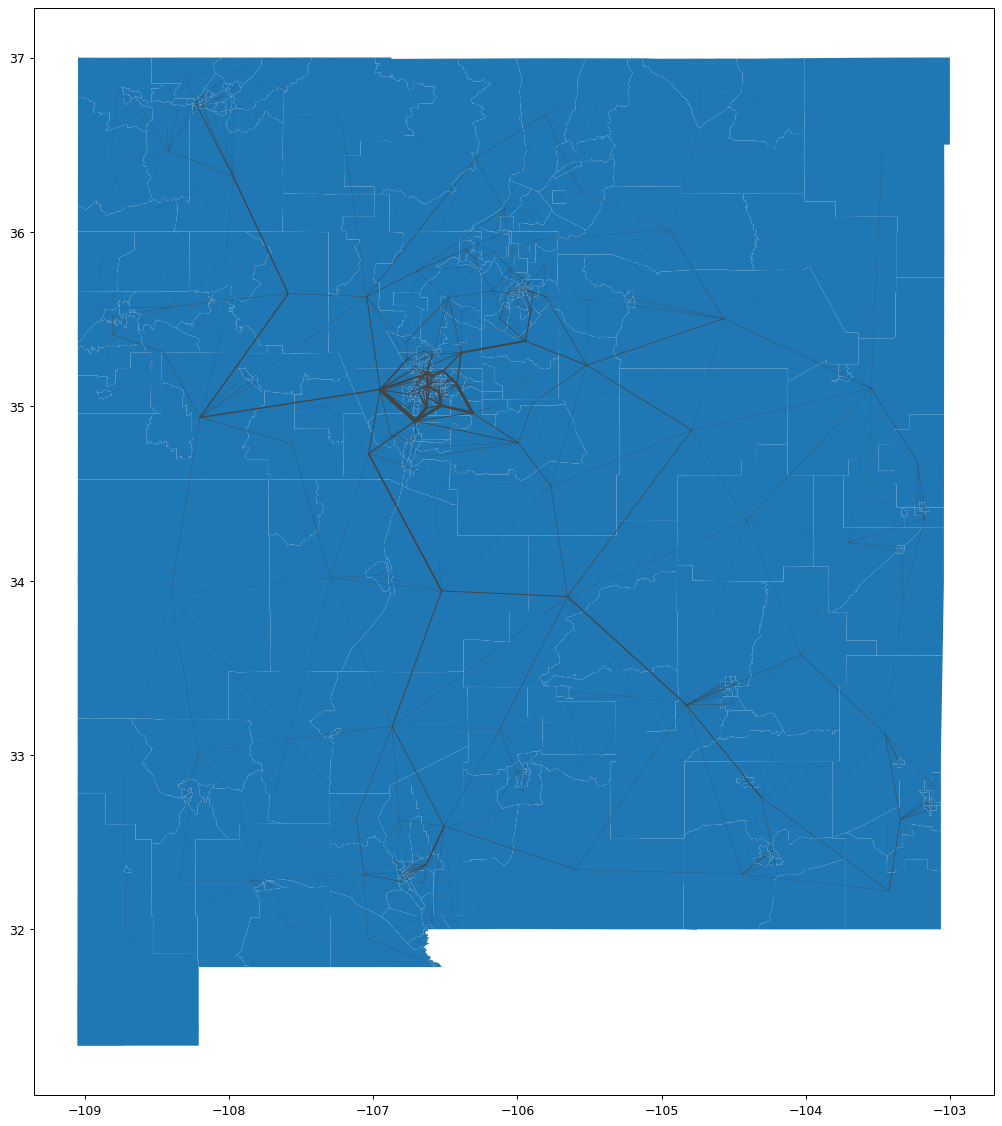

In [11]:
fig = plt.figure(1, figsize=(18, 16), dpi=90)
ax = fig.add_subplot(111)
zones.visualize_route_assignment(ax=ax)

In [12]:
zones.head()

Name  Production  \
GEOID                                                                      
35049001002  Census Tract 10.02, Santa Fe County, New Mexico        3612   
35049010400    Census Tract 104, Santa Fe County, New Mexico        3423   
35049001103  Census Tract 11.03, Santa Fe County, New Mexico        1731   
35049000600      Census Tract 6, Santa Fe County, New Mexico        2030   
35059950200      Census Tract 9502, Union County, New Mexico        4216   

             Attraction state county   tract STATEFP COUNTYFP TRACTCE NAME_y  \
GEOID                                                                          
35049001002           0    35    049  001002      35      049  001002  10.02   
35049010400           0    35    049  010400      35      049  010400    104   
35049001103           0    35    049  001103      35      049  001103  11.03   
35049000600           0    35    049  000600      35      049  000600      6   
35059950200           0    35    059  950200      35      059  950200   9502   

             ...     INTPTLAT      INTPTLON  \
GEOID        ...                              
35049001002  ...  +35.6654818  -105.9636628   
35049010400  ...  +35.6547921  -105.8796126   
35049001103  ...  +35.6560820  -105.9712060   
35049000600  ...  +35.6758514  -105.9446226   
35059950200  ...  +36.4880853  -103.4757229   

                                                      geometry  \
GEOID                                                            
35049001002  POLYGON ((-105.97726 35.66269, -105.97708 35.6...   
35049010400  POLYGON ((-105.93988 35.65773, -105.93959 35.6...   
35049001103  POLYGON ((-105.98489 35.65625, -105.98488 35.6...   
35049000600  POLYGON ((-105.95818 35.67497, -105.95643 35.6...   
35059950200  POLYGON ((-104.00934 36.69766, -104.00823 36.6...   

             ProductionAttractionSum  Production Density Attraction Density  \
GEOID                                                                         
35049001002                     3612         1731.320362                0.0   
35049010400                     3423           81.175154                0.0   
35049001103                     1731          777.802741                0.0   
35049000600                     2030         1244.532182                0.0   
35059950200                     4216            0.425692                0.0   

            ProductionAttractionSum Density Production density  \
GEOID                                                            
35049001002                     1731.320362       1.731320e-03   
35049010400                       81.175154       8.117515e-05   
35049001103                      777.802741       7.778027e-04   
35049000600                     1244.532182       1.244532e-03   
35059950200                        0.425692       4.256922e-07   

                        aea_centroid                 centroid  
GEOID                                                          
35049001002  POINT (35.665 -105.964)  POINT (35.665 -105.964)  
35049010400  POINT (35.654 -105.892)  POINT (35.654 -105.892)  
35049001103  POINT (35.656 -105.971)  POINT (35.656 -105.971)  
35049000600  POINT (35.676 -105.945)  POINT (35.676 -105.945)  
35059950200  POINT (36.482 -103.471)  POINT (36.482 -103.471)  

[5 rows x 25 columns]